<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#imports" data-toc-modified-id="imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>imports</a></span></li><li><span><a href="#data" data-toc-modified-id="data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#algo" data-toc-modified-id="algo-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>algo</a></span></li><li><span><a href="#wrap" data-toc-modified-id="wrap-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>wrap</a></span></li></ul></div>

# imports

In [1]:
import pandas as pd
import numpy as np
import cv2
import skimage.io
from imp import reload
import seam_carve as sc

# data

In [2]:
reload(sc)

<module 'seam_carve' from 'D:\\Courses\\shad2018\\CV\\hw2\\seam_carve.py'>

In [67]:
image = skimage.io.imread('./public_data/01_input/img.png')

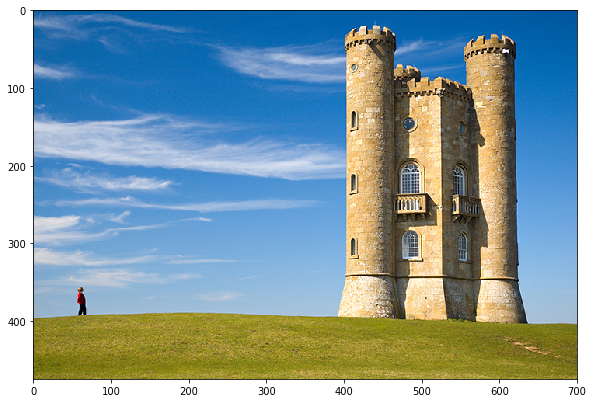

In [68]:
# image = image[:, 400:625]
sc.show_image(image)

# algo

In [69]:
y = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:, :, 0]

In [70]:
y_ = cv2.Sobel(y, cv2.CV_64F, 0, 1)
x_ = cv2.Sobel(y, cv2.CV_64F, 1, 0)

In [71]:
gradient = np.sqrt(x_ ** 2 + y_ ** 2)

In [72]:
sc.plt.gray()

<Figure size 432x288 with 0 Axes>

In [73]:
gradient

array([[  0.        ,   2.        ,  12.        , ...,   0.        ,
          8.        ,   0.        ],
       [ 14.        ,  17.02938637,  24.69817807, ...,   2.        ,
          7.21110255,   6.        ],
       [ 14.        ,  13.34166406,  22.6715681 , ...,   4.47213595,
          6.        ,   2.        ],
       ...,
       [  2.        ,  24.        ,  45.12205669, ...,  64.49806199,
         49.03060269,  60.        ],
       [ 42.        ,  30.46309242,  21.26029163, ..., 183.22117782,
        131.40015221, 126.        ],
       [  0.        ,   2.        ,  16.        , ..., 126.        ,
         28.        ,   0.        ]])

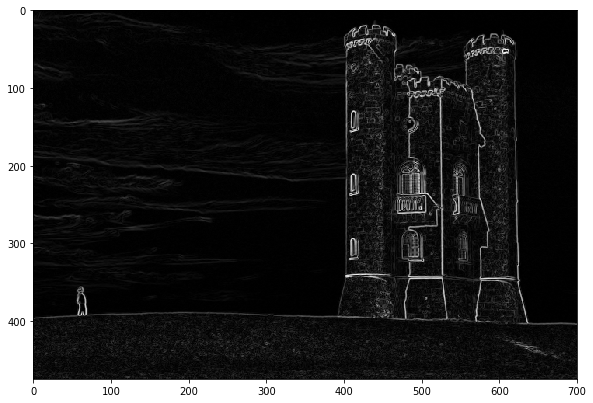

In [74]:
sc.show_image(gradient)

In [75]:
def argmin_on_slice(arr, i_from, i_to):
    if i_from < 0:
        return np.argmin(arr[0:i_to])
    elif i_to > len(arr):
        return np.argmin(arr[i_from:]) + i_from
    else:
        return np.argmin(arr[i_from:i_to]) + i_from
    return np.argmin(arr[max(i_from, 0):min(len(arr), i_to)])

In [76]:
def min_filter(image):
    result = np.copy(image)
    for i in range(image.shape[0] - 1):
        for j in range(image.shape[1]):
            result[i+1, j] += min(result[i, max(j-1, 0):min(image.shape[1], j+1)])
    return result

In [77]:
matrix = min_filter(gradient)

In [93]:
def resolve_seam(matrix):
    seam = []
    seam.append(np.argmin(matrix[-1]))
    for i in range(1, matrix.shape[0]):
        j_prev = seam[-1]
        j = argmin_on_slice(matrix[i], j_prev-1, j_prev+1)
        seam.append(j)
    mask = np.full(matrix.shape, False)
    for i in zip(range(matrix.shape[0]), seam):
        mask[i] = True
    return mask

In [94]:
mask = resolve_seam(matrix)

In [95]:
mask

array([[False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False,  True, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [99]:
image.shape

(475, 700, 3)

In [103]:
np.logical_not(mask)

array([[ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True, False,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

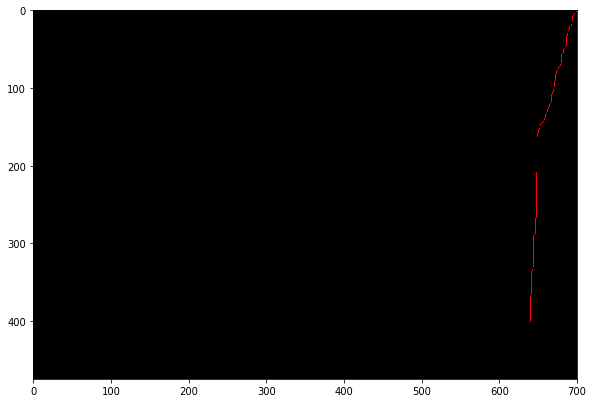

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [111]:
sc.show_channels(red=mask.astype(float))

# wrap

In [122]:
def seam_carve(image, mode='', mask=None):
    y = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:, :, 0]

    y_ = cv2.Sobel(y, cv2.CV_64F, 0, 1)
    x_ = cv2.Sobel(y, cv2.CV_64F, 1, 0)

    gradient = np.sqrt(x_ ** 2 + y_ ** 2)

#     sc.plt.gray()
#     sc.show_image(gradient)

    def argmin_on_slice(arr, i_from, i_to):
        if i_from < 0:
            return np.argmin(arr[0:i_to])
        elif i_to > len(arr):
            return np.argmin(arr[i_from:]) + i_from
        else:
            return np.argmin(arr[i_from:i_to]) + i_from
        return np.argmin(arr[max(i_from, 0):min(len(arr), i_to)])

    def min_filter(image):
        result = np.copy(image)
        for i in range(image.shape[0] - 1):
            for j in range(image.shape[1]):
                result[i+1, j] += min(result[i, max(j-1, 0):min(image.shape[1], j+1)])
        return result

    matrix = min_filter(gradient)

    def resolve_seam(matrix):
        seam = []
        seam.append(np.argmin(matrix[-1]))
        for i in range(1, matrix.shape[0]):
            j_prev = seam[-1]
            j = argmin_on_slice(matrix[i], j_prev-1, j_prev+1)
            seam.append(j)
        mask = np.full(matrix.shape, False)
        for i in zip(range(matrix.shape[0]), seam):
            mask[i] = True
        return mask

    mask = resolve_seam(matrix)

#     sc.show_channels(red=mask.astype(float))
    return image[~mask].reshape((image.shape[0], -1, 3))

0


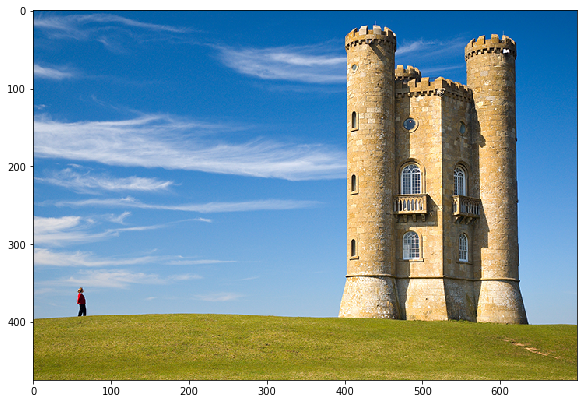

20


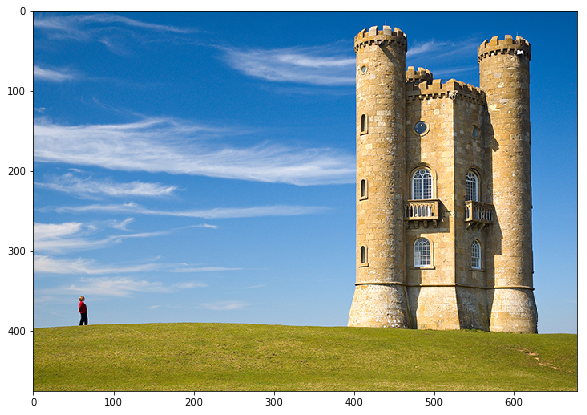

40


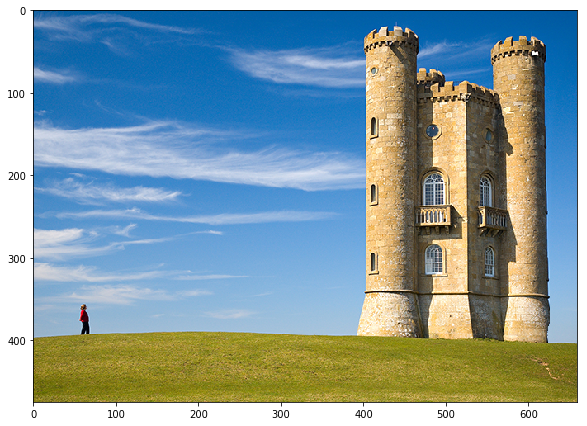

60


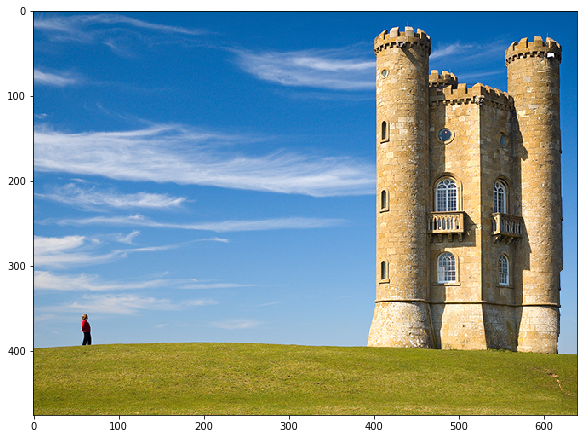

80


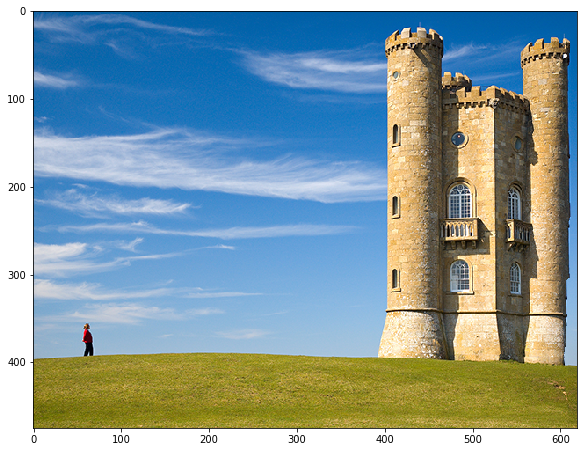

100


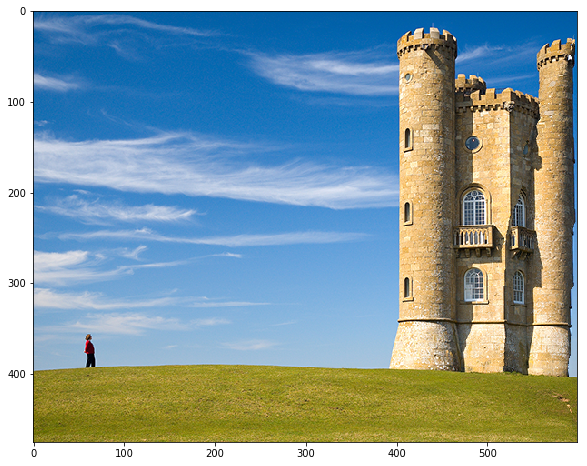

120


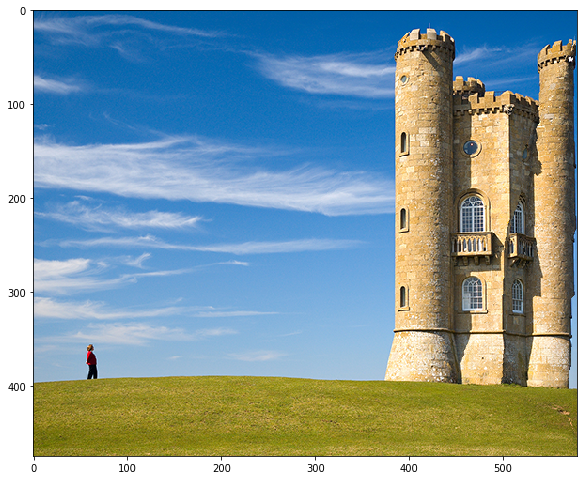

140


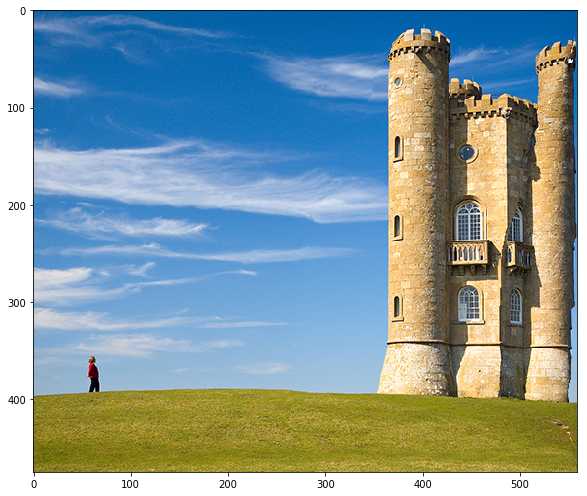

In [130]:
im = image.copy()
for i in range(150):
    im = seam_carve(im)
    if i % 20 == 0:
        print(i)
        sc.show_image(im)

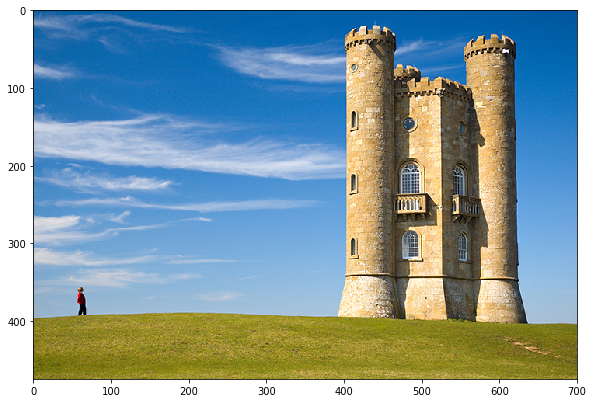

In [131]:
sc.show_image(image)

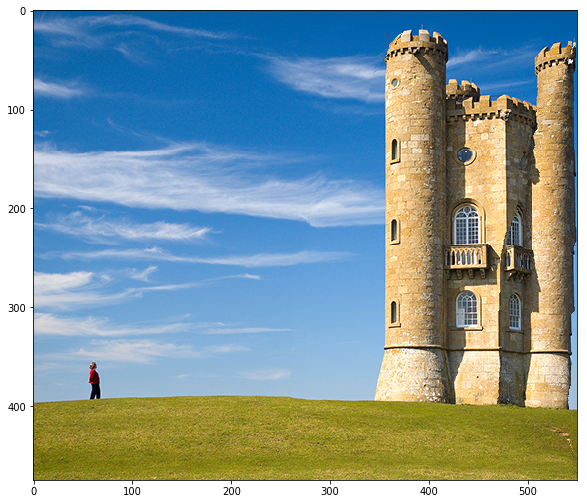

In [132]:
sc.show_image(im)

In [126]:
im.shape

(475, 685, 3)

In [3]:
def seam_carve(image, mode, mask=None):
    
    pass